In [1]:
# -*- coding: utf-8 -*-
"""
# @file name  : train_lenet.py
# @author     : tingsongyu
# @date       : 2019-09-07 10:08:00
# @brief      : 人民币分类模型训练
"""
"""
# @file name  : train_lenet_gpu.py
# @modified by: greebear
# @date       : 2019-10-26 13:25:00
# @brief      : 猫狗分类模型训练
"""
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot as plt
from lenet import LeNet, MyNet
from DogCat_dataset import DogCatDataset


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


set_seed()  # 设置随机种子

# 参数设置
MAX_EPOCH = 40
BATCH_SIZE = 512
LR = 0.001
log_interval = 10
val_interval = 1

In [2]:
# ============================ step 1/5 数据 ============================

split_dir = os.path.join("..", "data", "cad_split")
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

# 构建MyDataset实例
train_data = DogCatDataset(data_dir=train_dir, transform=train_transform)
valid_data = DogCatDataset(data_dir=valid_dir, transform=valid_transform)

# 构建DataLoder
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=16)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, num_workers=16)

In [3]:
# ============================ step 2/5 模型 ============================

net = MyNet(classes=2)
net.initialize_weights()

In [4]:
net.to("cuda")

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [5]:
# ============================ step 3/5 损失函数 ============================
criterion = nn.CrossEntropyLoss()   

In [6]:
# ============================ step 4/5 优化器 ============================
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-1)                        # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

In [7]:
# inputs.to("cuda").device

In [8]:
from torchsummary import summary
summary(net, input_size=(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]           2,368
       BatchNorm2d-2         [-1, 16, 112, 112]              32
            Conv2d-3           [-1, 32, 56, 56]           4,640
       BatchNorm2d-4           [-1, 32, 56, 56]              64
            Conv2d-5           [-1, 32, 56, 56]           9,248
       BatchNorm2d-6           [-1, 32, 56, 56]              64
            Conv2d-7           [-1, 64, 28, 28]          18,496
       BatchNorm2d-8           [-1, 64, 28, 28]             128
            Conv2d-9           [-1, 64, 28, 28]          36,928
      BatchNorm2d-10           [-1, 64, 28, 28]             128
           Conv2d-11          [-1, 128, 14, 14]          73,856
      BatchNorm2d-12          [-1, 128, 14, 14]             256
           Conv2d-13          [-1, 128, 14, 14]         147,584
      BatchNorm2d-14          [-1, 128,

In [9]:
valid_acc = list()

In [10]:
# ============================ step 5/5 训练 ============================
train_curve = list()
valid_curve = list()

for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()
    for i, data in enumerate(train_loader):
        # forward
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().cpu().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

    scheduler.step()  # 更新学习率

    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        net.eval()
        with torch.no_grad():
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                inputs = inputs.to("cuda")
                labels = labels.to("cuda")
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).squeeze().sum().cpu().numpy()

                loss_val += loss.item()

            valid_curve.append(loss.item())
            valid_acc.append(correct_val / total_val)
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} 【Acc:{:.2%}】".format(
                epoch, MAX_EPOCH, j+1, len(valid_loader), loss_val, correct_val / total_val))
            

Training:Epoch[000/040] Iteration[010/040] Loss: 1.1257 Acc:53.55%
Training:Epoch[000/040] Iteration[020/040] Loss: 0.9067 Acc:54.85%
Training:Epoch[000/040] Iteration[030/040] Loss: 0.8051 Acc:56.00%
Training:Epoch[000/040] Iteration[040/040] Loss: 0.7202 Acc:56.97%
Valid:	 Epoch[000/040] Iteration[005/005] Loss: 3.2791 【Acc:58.28%】
Training:Epoch[001/040] Iteration[010/040] Loss: 0.7098 Acc:60.10%
Training:Epoch[001/040] Iteration[020/040] Loss: 0.6851 Acc:60.38%
Training:Epoch[001/040] Iteration[030/040] Loss: 0.6392 Acc:61.52%
Training:Epoch[001/040] Iteration[040/040] Loss: 0.6527 Acc:61.80%
Valid:	 Epoch[001/040] Iteration[005/005] Loss: 3.1807 【Acc:63.84%】
Training:Epoch[002/040] Iteration[010/040] Loss: 0.6567 Acc:63.28%
Training:Epoch[002/040] Iteration[020/040] Loss: 0.6268 Acc:63.86%
Training:Epoch[002/040] Iteration[030/040] Loss: 0.6064 Acc:64.96%
Training:Epoch[002/040] Iteration[040/040] Loss: 0.5873 Acc:66.03%
Valid:	 Epoch[002/040] Iteration[005/005] Loss: 3.9561 【Acc:

Training:Epoch[024/040] Iteration[030/040] Loss: 0.1858 Acc:94.11%
Training:Epoch[024/040] Iteration[040/040] Loss: 0.1954 Acc:94.11%
Valid:	 Epoch[024/040] Iteration[005/005] Loss: 1.0870 【Acc:91.64%】
Training:Epoch[025/040] Iteration[010/040] Loss: 0.1871 Acc:93.98%
Training:Epoch[025/040] Iteration[020/040] Loss: 0.1898 Acc:93.87%
Training:Epoch[025/040] Iteration[030/040] Loss: 0.1765 Acc:94.20%
Training:Epoch[025/040] Iteration[040/040] Loss: 0.2005 Acc:94.27%
Valid:	 Epoch[025/040] Iteration[005/005] Loss: 1.0762 【Acc:91.48%】
Training:Epoch[026/040] Iteration[010/040] Loss: 0.1860 Acc:93.69%
Training:Epoch[026/040] Iteration[020/040] Loss: 0.1844 Acc:93.77%
Training:Epoch[026/040] Iteration[030/040] Loss: 0.1864 Acc:93.80%
Training:Epoch[026/040] Iteration[040/040] Loss: 0.1752 Acc:93.90%
Valid:	 Epoch[026/040] Iteration[005/005] Loss: 1.0784 【Acc:91.72%】
Training:Epoch[027/040] Iteration[010/040] Loss: 0.1807 Acc:94.57%
Training:Epoch[027/040] Iteration[020/040] Loss: 0.1714 Acc

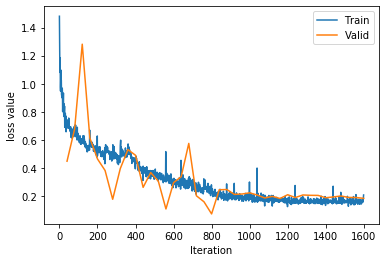

In [11]:
train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

In [12]:
torch.save(net, "./1")

In [20]:
net = torch.load("./1")